# Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## y = kx + b

Let's start with a toy 1D problem, where the true dependence is
$$y=k\cdot x+b+\text{noise}$$

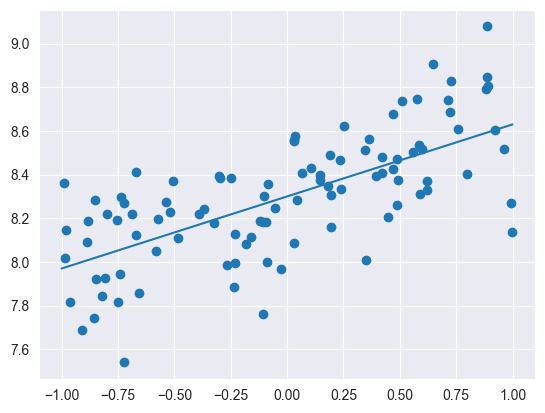

In [6]:
def linear_function(x):
  return 0.33 * x + 8.3

def gen_dataset(N, func, lims=(-1., 1.), noise_lvl=0.2):
  x = np.random.uniform(*lims, size=N)
  y = func(x) + noise_lvl * np.random.normal(size=x.shape)
  return x[:,None], y

X, y = gen_dataset(100, linear_function)
x = np.linspace(-1, 1, 101)
plt.plot(x, linear_function(x))
plt.scatter(X, y);

### `LinearRegression` from `sklearn`

[0.34029218] 8.305579018285211


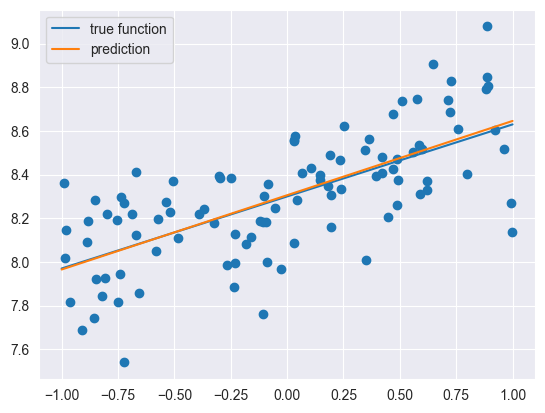

In [8]:
# The following class implements the analytical solution for
# linear regression with the MSE loss
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X, y)

x = np.linspace(-1, 1, 101)
plt.plot(x, linear_function(x), label='true function')
plt.scatter(X, y)
plt.plot(x, model.predict(x[:,None]), label='prediction')
plt.legend()

print(model.coef_, model.intercept_)

### Sidenote: making contour plots

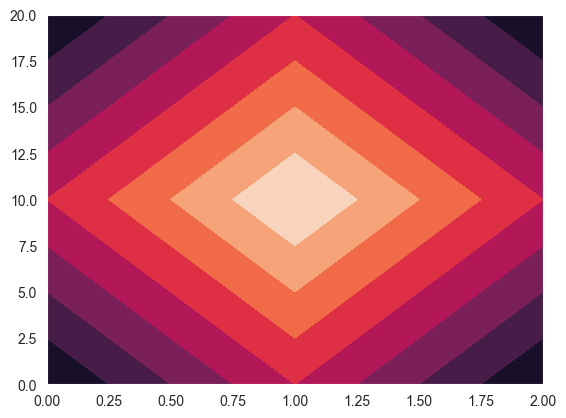

In [9]:
### Sidenote: making contour plots (level maps)

plt.contourf(
    [[0., 1., 2.], # matrix of X
     [0., 1., 2.],
     [0., 1., 2.]],
    [[ 0.,  0.,  0.], # matrix of Y
     [10., 10., 10.],
     [20., 20., 20.]],
    [[-1., 0., -1.], # matrix of Z
     [ 0., 1.,  0.],
     [-1., 0., -1.]]
);

In [6]:
### 2D matrices of X and Y (as above) can be
### created from 1D vectors using np.meshgrid:

for i in np.meshgrid([0., 1., 2.], [0., 10., 20.]):
  print(i)


[[0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]]
[[ 0.  0.  0.]
 [10. 10. 10.]
 [20. 20. 20.]]


### MSE as a function of model parameters

Let's see what MSE looks like as a function of model parameters **(2 points)**:

In [9]:
Z = np.linspace(-50, 49, 100)

In [54]:
X[np.newaxis, :, 0].shape

(1, 100)

In [28]:
ww

array([[-10.        ,  -9.59183673,  -9.18367347, ...,   9.18367347,
          9.59183673,  10.        ],
       [-10.        ,  -9.59183673,  -9.18367347, ...,   9.18367347,
          9.59183673,  10.        ],
       [-10.        ,  -9.59183673,  -9.18367347, ...,   9.18367347,
          9.59183673,  10.        ],
       ...,
       [-10.        ,  -9.59183673,  -9.18367347, ...,   9.18367347,
          9.59183673,  10.        ],
       [-10.        ,  -9.59183673,  -9.18367347, ...,   9.18367347,
          9.59183673,  10.        ],
       [-10.        ,  -9.59183673,  -9.18367347, ...,   9.18367347,
          9.59183673,  10.        ]])

In [45]:
(ww[:, :, np.newaxis] * Z[np.newaxis, np.newaxis, :] + bb[:,:,np.newaxis] - y[np.newaxis, np.newaxis, :]).shape

(50, 50, 100)

In [57]:
np.mean((ww[:, :, np.newaxis] * X[np.newaxis, np.newaxis, :, 0] + bb[:,:,np.newaxis] - y[np.newaxis, np.newaxis, :])**2, axis=2).shape

(50, 50)

In [117]:
MSE_map.shape

(50, 50)

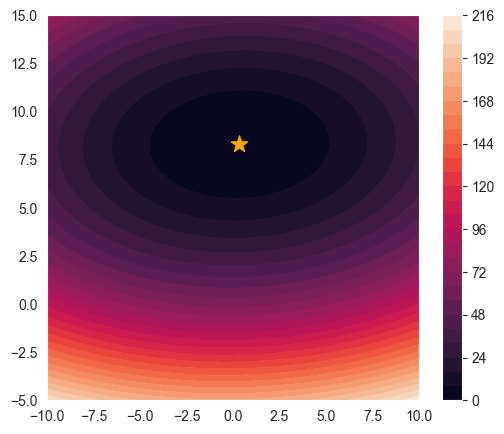

In [11]:
# Creating a grid of model parameter values:
ww, bb = np.meshgrid(
    np.linspace(-10., 10., 50),
    np.linspace(-5., 15., 50)
)

# Your turn: calculate the map of MSE values on the grid defined above, i.e.
# for each (w, b) in (ww, bb) calculate MSE for the model y = w * x + b.
# Avoid using loops.
MSE_map = np.mean((ww[..., None] * X[None, None, :, 0] + bb[..., None] - y[None, None, :])**2, axis=2)

# Automatic checks
assert MSE_map.shape == ww.shape, print(MSE_map.shape)
for i in [0, -1]:
  for j in [0, -1]:
    assert np.isclose(
        MSE_map[i, j],
        ((ww[i, j] * X.ravel() + bb[i, j] - y)**2).mean()
    ), f'assert failed for point {i, j}'

# Plotting:
plt.figure(figsize=(6, 5), dpi=100)
plt.colorbar(plt.contourf(ww, bb, MSE_map, levels=30))
plt.scatter(model.coef_, model.intercept_, marker='*', s=150, c='orange');

## Polynomial fit

Now let's take some arbitrary function:

In [12]:
def true_function(x):
  return np.sin(3 * x + 0.8) + np.sin(1. / (x + 1.23))

Obviously, we won't get a good fit with an ordinary linear regression:

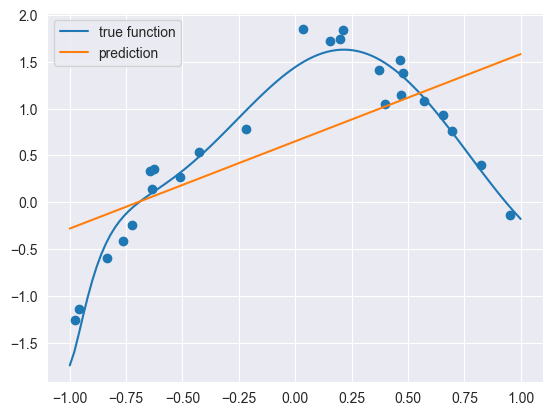

In [13]:
model = LinearRegression()
X, y = gen_dataset(25, true_function)

model.fit(X, y)

x = np.linspace(-1, 1, 101)
plt.plot(x, true_function(x), label='true function')
plt.scatter(X, y);
plt.plot(x, model.predict(x[:,None]), label='prediction')
plt.legend();

### `PolynomialFeatures` and pipelines

Even though our design matrix has only one column:
$$X=
\begin{pmatrix}
x_1 \\
x_2 \\
\vdots \\
x_N
\end{pmatrix},
$$
we can expand it with powers of $x$ to fit a polynomial:
$$X'=
\begin{pmatrix}
x_1 & (x_1)^2 & \ldots & (x_1)^k \\
x_2 & (x_2)^2 & \ldots & (x_2)^k \\
\vdots & \vdots & \ddots & \vdots \\
x_N & (x_N)^2 & \ldots & (x_N)^k
\end{pmatrix},
$$

such that:

$$\frac{1}{N}\left\Vert X'\cdot w - y\right\Vert^2\to \underset{w}{\text{min}}$$

This functionality is implemented in `sklearn.preprocessing.PolynomialFeatures`:

In [14]:
from sklearn.preprocessing import PolynomialFeatures

poly_expand = PolynomialFeatures(3)
poly_expand.fit_transform(np.arange(5)[:,None])

array([[ 1.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.]])

One can combine `PolynomialFeatures` (and any other transformers) along with the model into a single pipeline:

In [15]:
from sklearn.pipeline import make_pipeline

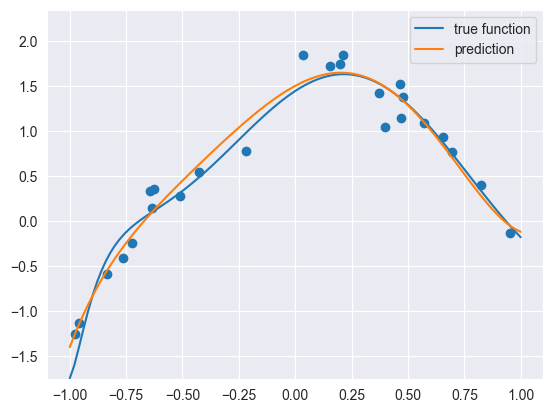

In [16]:
# The first parameter is the power of expansion. Try playing around with it.
poly_expand = PolynomialFeatures(5, include_bias=False)
linear_model = LinearRegression()
model = make_pipeline(
    poly_expand, linear_model
)

model.fit(X, y)

x = np.linspace(-1, 1, 101)
plt.plot(x, true_function(x), label='true function')
plt.scatter(X, y);
plt.plot(x, model.predict(x[:,None]), label='prediction')
plt.ylim(y.min() - 0.5, y.max() + 0.5)
plt.legend();

Now we want to plot 2D projections of MSE as a function of model parameters **(2 points)**.

In [18]:
from tqdm import trange, tqdm

100%|██████████| 6/6 [00:00<00:00,  9.84it/s]


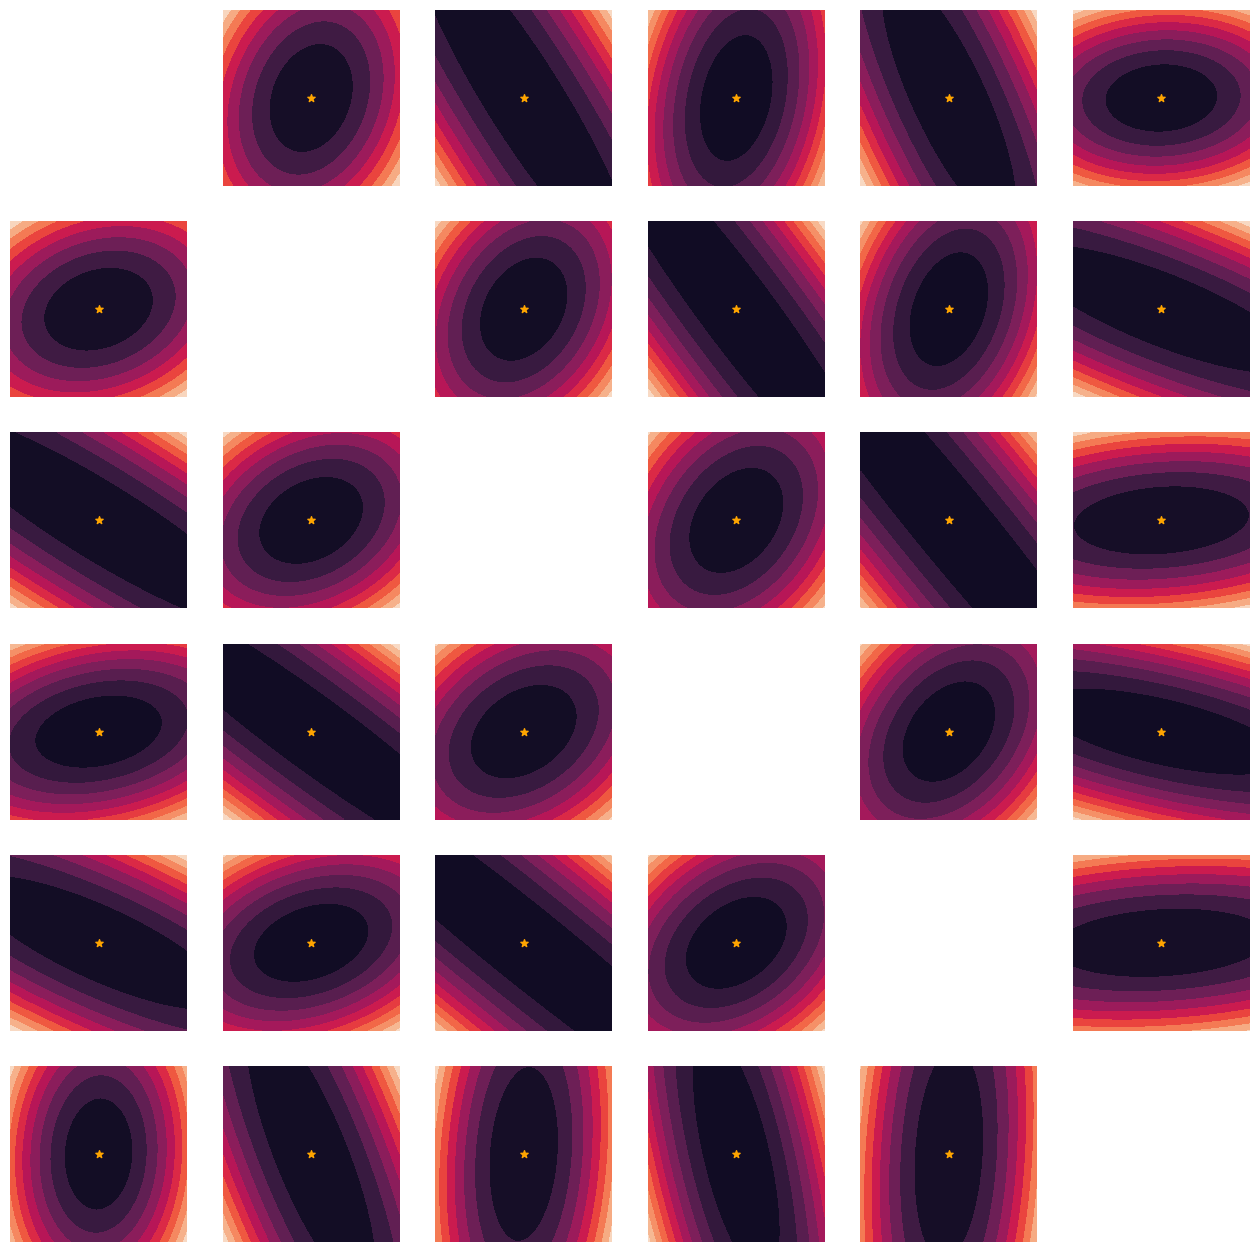

In [59]:
# Combine the weights and the bias into a single parameter vector
solution = np.concatenate([linear_model.coef_, [linear_model.intercept_]])

# Calculate the power expansion of the features
X_expanded = np.concatenate([
    poly_expand.transform(X), np.ones(shape=(len(X), 1))
], axis=1)

# We'll plot a large matrix of plots, so let's create
# a 16 by 16 inch canvas
plt.figure(figsize=(16, 16))

# We'll loop over all pairs of weights
i_img = 0
for dim1 in trange(len(solution)):
  for dim2 in range(len(solution)):
    i_img += 1
    # Skip the diagonal
    if dim1 == dim2: continue

    # Create the grid of parameter values
    ww1, ww2 = np.meshgrid(
        np.linspace(solution[dim1] - 1000., solution[dim1] + 1000., 50),
        np.linspace(solution[dim2] - 1000., solution[dim2] + 1000., 50),
    )

    # Your turn! To calculate the map of MSE values, let's first
    # create `param_grid` - a 3D array of parameter values of the
    # following shape: (len(solution), ww1.shape[0], ww1.shape[1])
    #
    # I.e. `param_grid[i, :, :]` should equal to:
    #     `ww1` if `i` equals `dim1`;
    #     `ww2` if `i` equals `dim2`;
    #     `solution[i]` otherwise.
    
    param_grid = np.empty(shape= (len(solution),) + ww1.shape, dtype=float)
    param_grid[:] = solution[:,None,None]
    param_grid[dim1] = ww1
    param_grid[dim2] = ww2
    # Automatic checks
    assert param_grid.shape == (len(solution),) + ww1.shape
    assert np.allclose(param_grid[dim1], ww1)
    assert np.allclose(param_grid[dim2], ww2)
    assert all(
        np.allclose(param_grid[i], solution[i])
        for i in range(len(solution)) if i not in (dim1, dim2)
    )

    # Your turn! Now it's time to calculate the MSE map, i.e. for each grid
    # element (i, j), you want `MSE_map[i, j]` to be equal to the MSE
    # for the model defined by parameters `param_grid[:, i, j]`.
    # MSE_map = np.mean((np.sum(param_grid[..., None] * X_expanded.T[:, None, None], axis=0) - y[None, None, :]) ** 2, axis=2)  # мое оригинальное
    MSE_map = np.mean((np.sum(param_grid[None, ...] * X_expanded[..., None, None], axis=1) - y[..., None, None]) ** 2, axis=0)  # получше
    # Automatic checks
    assert MSE_map.shape == ww1.shape
    for i in [0, -1]:
      for j in [0, -1]:
        assert np.isclose(
            ((X_expanded @ param_grid[:, i, j] - y)**2).mean(),
            MSE_map[i, j]
        ), f'Check failed for point {i, j}'

    plt.subplot(len(solution), len(solution), i_img)
    plt.axis('off')

    plt.contourf(ww1, ww2, MSE_map, levels=10);
    plt.scatter(solution[dim1], solution[dim2], marker='*', s=30, c='orange')

In [35]:
X_expanded.shape

(25, 6)

In [36]:
param_grid.shape

(6, 50, 50)

In [28]:
y.shape

(25,)

In [44]:
np.mean((np.sum(param_grid.reshape((50, 50, 6))[:,:,:,None] * X_expanded.reshape(6, 25)[None, :], axis=2) - y[None, None, :]) ** 2, axis=2).shape

(50, 50)

In [57]:
np.mean((np.sum(param_grid[..., None] * X_expanded.T[:, None, None], axis=0) - y[None, None, :]) ** 2, axis=2).shape

(50, 50)

In [102]:
np.mean(np.sum(param_grid[:, :, :, np.newaxis] * X[np.newaxis, np.newaxis, np.newaxis, :, 0] - y[np.newaxis, np.newaxis, np.newaxis, :], axis=0), axis=2).shape

(50, 50)

In [51]:
param_grid.reshape(50, 50, 6)[0,0]

array([-998.65169203, -957.8353655 , -917.01903897, -876.20271244,
       -835.38638591, -794.57005938])

In [52]:
param_grid[:,0,0]

array([-9.98651692e+02, -1.00262577e+03, -2.49559825e+00,  3.68185696e-01,
        1.78641814e+00,  1.50058117e+00])

In [53]:
X_expanded.T

array([[-9.61094988e-01, -2.18342369e-01,  4.77431349e-01,
         4.00315602e-01,  2.09882261e-01,  1.52689340e-01,
         1.99752070e-01, -7.22464381e-01, -9.76785630e-01,
        -8.34938896e-01, -6.34277399e-01,  4.68551079e-01,
         9.54505988e-01,  3.69957042e-01,  3.32805574e-02,
        -6.24481392e-01, -6.42165065e-01,  8.23795149e-01,
         6.94093482e-01,  4.63081294e-01, -5.11910500e-01,
        -4.24574787e-01,  5.70803336e-01,  6.57565522e-01,
        -7.64124565e-01],
       [ 9.23703575e-01,  4.76733902e-02,  2.27940693e-01,
         1.60252582e-01,  4.40505635e-02,  2.33140346e-02,
         3.99008896e-02,  5.21954782e-01,  9.54110168e-01,
         6.97122961e-01,  4.02307819e-01,  2.19540114e-01,
         9.11081682e-01,  1.36868213e-01,  1.10759550e-03,
         3.89977009e-01,  4.12375970e-01,  6.78638447e-01,
         4.81765761e-01,  2.14444285e-01,  2.62052360e-01,
         1.80263750e-01,  3.25816448e-01,  4.32392416e-01,
         5.83886350e-01],
    

Note the relation between the amount of overfitting and correlation between parameters.

## Gradient descent

Let's look at MSE as a function of parameters:
$$\text{MSE}(w)=\frac{1}{N}\left\Vert X'\cdot w - y\right\Vert^2$$

Instead of minimizing it analytically, we can use numeric optimization with gradient descent. I.e. do the following procedure iteratively:
$$w\leftarrow w-\alpha\cdot\frac{\partial\text{MSE}(w)}{\partial w},$$
for some constant *learning rate* $\alpha$.

For the task below you'll need to derive the analytical formula for $\frac{\partial\text{MSE}(w)}{\partial w}$. **Note, that $w$ is a vector!** If not sure how to do it, check out the [matrix calculus cheat sheet](https://en.wikipedia.org/wiki/Matrix_calculus#Identities).

When done **(2 points)**, play around with the power of the polynomial expansion, learning rate and the number of gradient descent steps.

100%|██████████| 1000/1000 [00:00<00:00, 32265.37it/s]


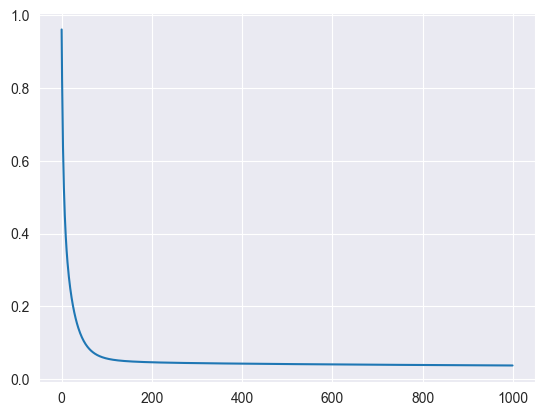

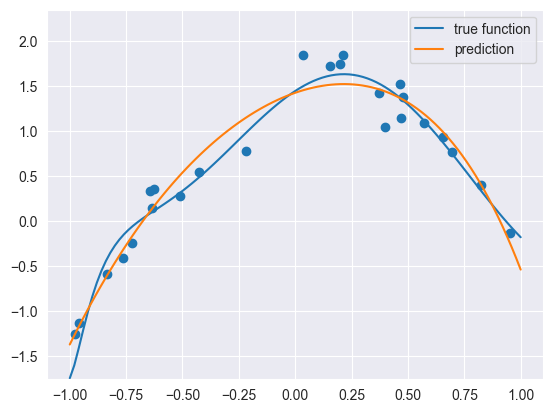

In [60]:
# Initialize the model parameters with zeros
w = np.zeros(dtype=float, shape=X_expanded.shape[1])

loss_values = [] # a list to keep track of how the loss value changes
learning_rate = 0.1

# Training loop
for _ in trange(1000):
  # Your turn: calculate the gradient of MSE with respect to w:
  gradient = ((1./X_expanded.shape[0]) * (2.) * (X_expanded@w - y)) @ X_expanded # не мое

  # Automatic checks
  assert gradient.shape == w.shape
  assert (
      ((X_expanded @ w - y)**2).mean() > 
      ((X_expanded @ (w - 1.e-6 * gradient) - y)**2).mean()
  )

  # Gradient descent step
  w -= learning_rate * gradient

  # Calculate and record the new loss value
  loss_values.append(
      ((X_expanded @ w - y)**2).mean()
  )

# Plotting the evolution of loss values
plt.plot(loss_values);
plt.show()


# Plotting the solution
x = np.linspace(-1, 1, 101)
x_expanded = np.concatenate([
    poly_expand.transform(x[:,None]),
    np.ones(shape=(len(x), 1))
], axis=1)
plt.plot(x, true_function(x), label='true function')
plt.scatter(X, y);
plt.plot(x,
         x_expanded @ w, label='prediction')
plt.ylim(y.min() - 0.5, y.max() + 0.5)
plt.legend();

Did you notice that numeric solution is less prone to overfitting? Some intuition for that can be found in this post: https://distill.pub/2017/momentum/ (though not explicitly).

## Here comes the overfitting

What is going to happen if we increase the number of powers we use? 

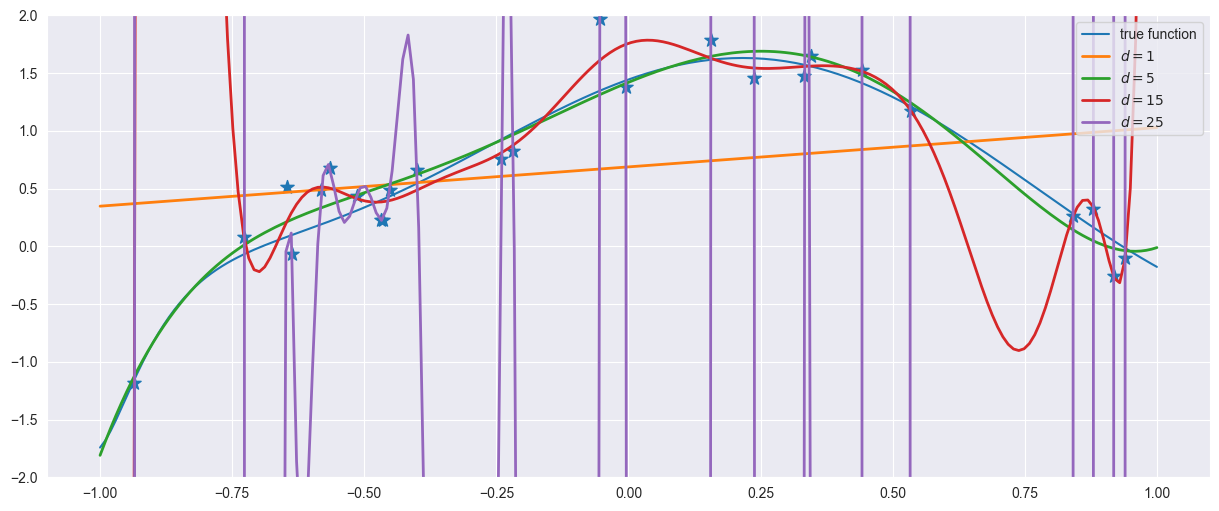

In [61]:
X, y = gen_dataset(25, true_function)

# Define the set of powers to be used generating the features
set_of_powers =[ 1, 5, 15, 25 ]

# Plotting the ground truth
plt.figure(figsize=(15,6))
x = np.linspace(-1, 1, 200)
plt.plot(x, true_function(x), label='true function')
plt.scatter(X, y,marker='*', s = 100);
plt.ylim(-2, 2)

# Adding plots for every single value in the set of powers using the pipeline
for d in set_of_powers:
    poly_expand = PolynomialFeatures(d, include_bias=False)
    model = make_pipeline(poly_expand, LinearRegression())
    model.fit(X, y)
    plt.plot(x, model.predict(x[:,None]),linewidth=2, label="$d=%d$" % d)
plt.legend(loc = 1)
plt.title
plt.show()

Using `sklearn` LinearRegression, it is possible to fit every single point, but it is not the objective we try to achieve.

## Bonus. Custom LinearRegression class

Based on [OML](https://github.com/girafe-ai/ml-mipt) open materials.

Let's wrap our previous Gradient Descent experiments into LR class, using `sklearn` standard interfaces to implement it **(3 points)**.
You can find [the base classes](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.base) for all of the most common problems.
So, we need to inherit base class and implement main stages of regression pipeline methods:
* hyperparameter initialization - constructor
* parameters training on known objects - fit method
* target estimation for unknown objects - predict method

In [63]:
from sklearn.base import BaseEstimator, RegressorMixin

In [64]:
class LinearRergessionSGD(BaseEstimator, RegressorMixin): # inherit base class 
    def __init__(self,
                 batch_size: int=10,
                 lr: float=1e-2,
                 n_iters: int=10) -> None:
        # You can read more about Annotations here: https://www.python.org/dev/peps/pep-3107/
        self.batch_size = batch_size
        self.lr = lr
        self.n_iters = n_iters
        
        # We are going to use the history plotting the trajectory
        self.w_history = [] 

    def fit(self, X, Y):
        # initialize the weights
        w = np.zeros(X.shape[1])
        
        n_objects = len(X)
        
        for i in range(self.n_iters):
            # Sample random indices of objects to be used during the step
            sample_indices = np.random.randint(0, X.shape[0], self.batch_size)
            
            # Make the step
            w -= self.lr * ((1./X[sample_indices].shape[0]) * (2.) * (X[sample_indices]@w - Y[sample_indices])) @ X[sample_indices]
            self.w_history.append(w.copy())
            
        self.w = w
        return self

    def predict(self, X):
        # Return the results of your model applied to X
        return X@self.w

Now we can have a look on the weights' trajectory through the training process. 

In [65]:
n_features = 2 
n_objects = 300
batch_size = 10
num_steps = 15
np.random.seed(43)

In [66]:
# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features))
X = np.random.uniform(-5, 5, (n_objects, n_features))

# Let's make different scales of features
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] 

# Here you define the *true* target value
Y = X.dot(w_true) + np.random.normal(0, 1, n_objects) 

In [67]:
from sklearn.model_selection import train_test_split
# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, Y)

# Fit the model of our custom class
own_lr = LinearRergessionSGD(batch_size=batch_size, n_iters=num_steps).fit(x_train, y_train)
# Get the weights
w_list = np.array(own_lr.w_history) 

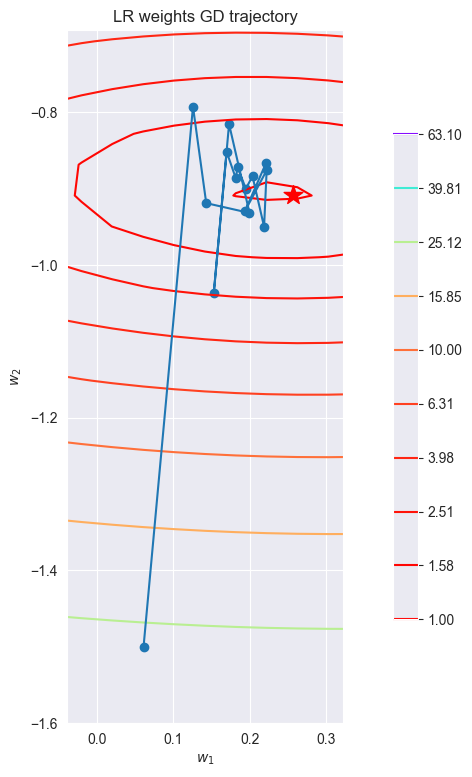

In [72]:
# Compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100)) 

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))

plt.figure(figsize=(13, 9))
plt.title('LR weights GD trajectory')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
plt.gca().set_aspect('equal')

# Visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1.8, num=10), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.7)

# Visualize the trajectory
plt.scatter(w_true[0], w_true[1], c='r',marker = '*', s = 200)
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

## Here we go again...

Now, instead of `sklearn` Linear Regression we use our own SGD-based impementation.

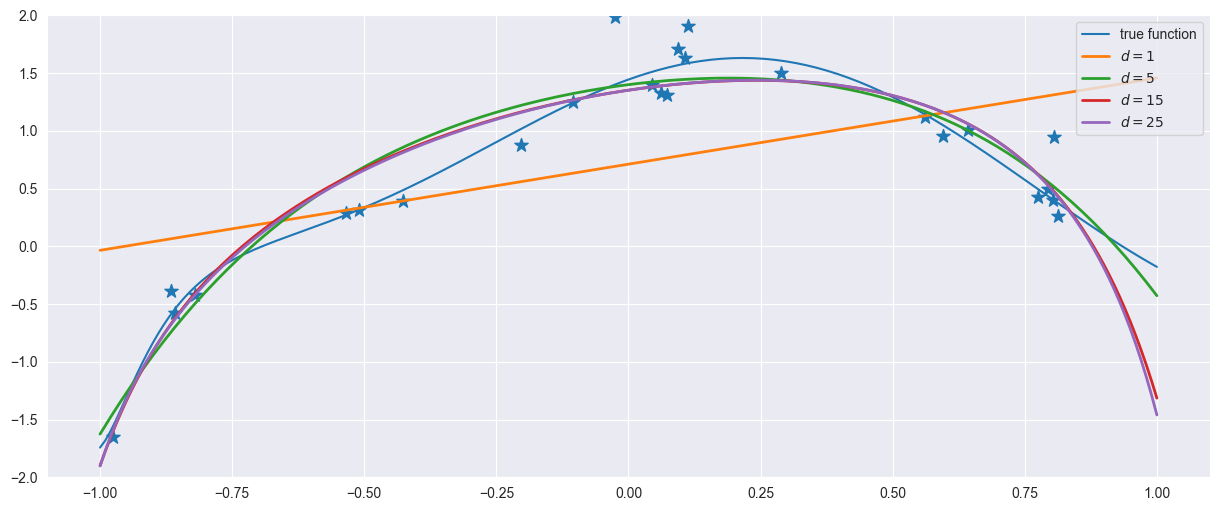

In [73]:
X, y = gen_dataset(25, true_function)
set_of_powers =[ 1, 5, 15, 25 ]

plt.figure(figsize=(15,6))
x = np.linspace(-1, 1, 200)
plt.plot(x, true_function(x), label='true function')
plt.scatter(X, y,marker='*', s = 100);
plt.ylim(-2, 2)

for d in set_of_powers:
    poly_expand = PolynomialFeatures(d, include_bias=True)
    model = make_pipeline(poly_expand, LinearRergessionSGD(lr=1e-2,n_iters=2000))
    model.fit(X, y)
    plt.plot(x, model.predict(x[:,None]),linewidth=2, label="$d=%d$" % d)
    
plt.legend(loc = 1)
plt.show()